# Introduction

In [1]:
import pandas as pd
import numpy as np
import calendar
pd.set_option('display.max_columns', 100)

## Function

### Preprocessing Data

In [2]:
def X_preprocessing(df):
    '''
    '''
    
    # checking resposne variable
    column_interval_dup = column_interval.copy()
    if 'SalePrice' not in df:
        column_interval_dup.remove('SalePrice')
        
    # drop useless column "id"
    df = df.drop('Id', axis=1)
    
    df_nominal = df[column_nominal].copy()
    df_interval = df[column_interval_dup].copy()

    # preprocessing on interval dataframe
    ## simple null value imputation: interval to 0
    ## concat to the actual table
    df_interval = df_interval.fillna(0)
    df = df.drop(column_interval_dup, axis=1)
    df = pd.concat([df, df_interval], axis=1)

    # binary data convesion
    df['CentralAir'] = df[column_binary]['CentralAir'].apply(lambda x: 1 if x == 'Y' else 0)

    # preprocessing on nonimal dataframe
    ## simple null value imputation: categorical to NaN
    df_nominal = df_nominal.drop(col_major_missing, axis = 1)
    df_nominal = df_nominal.fillna(nominal_mode)
    

    ## convert MSSubClass value to string
    df_nominal['MSSubClass'] = df_nominal['MSSubClass'].astype('string')
    df_nominal['MSSubClass'] = df_nominal['MSSubClass'].apply(lambda x: 'MSSC_'+x)

    ## all set, convert all the categorical variable to dummies variables
    df_nominal = pd.get_dummies(df_nominal)

    ## concat to the actual table
    df = df.drop(column_nominal, axis=1)
    df = pd.concat([df, df_nominal], axis=1)

    # preprocessing on time dataframe
    ## time approach-renovation: comparing to the year built
    ## time approach-soldyear: comparing to the year built
    df['YearRemodAdd'] = df[column_time]['YearRemodAdd'] - df[column_time]['YearBuilt'] 
    df['YrSold'] = df[column_time]['YrSold'] - df[column_time]['YearBuilt']

    ## time approach-built: comparing to the oldest listing on the market
    df_yrbuilt_min = df[column_time]['YearBuilt'].min()
    df['YearBuilt'] = df[column_time]['YearBuilt'].apply(lambda x: x - df_yrbuilt_min)

    ## time apprach-soldmonth: to dummies variable
    df['MoSold'] = df['MoSold'].apply(lambda x: 'sold_'+calendar.month_name[x])
    df_dum_months = pd.get_dummies(df['MoSold'])
    df = df.drop(['MoSold'], axis=1)

    df = pd.concat([df,df_dum_months], axis=1)

    if 'SalePrice' in df:
    # final to split between dependent variable to resposne
        X = df.drop('SalePrice', axis=1)
        y = df['SalePrice']

    else:
        print('This is test dataset return only X...')
        X = df.copy()
        y = None

    return X, y

## Import data(s)

In [3]:
train_df = pd.read_csv('data/train.csv')
df_cols_process = pd.read_csv('data/column_types_and_process_imputation.csv')

In [4]:
df_cols_process.head()

,no,column,count null,data type,description,data types,data process,imputation
0,1,Id,1460 non-null,int64,unique,useless,drop,NaN
1,2,MSSubClass,1460 non-null,int64,Identifies the type of dwelling involved in th...,nominal,one-hot-encoding,NaN
2,3,MSZoning,1460 non-null,object,Identifies the general zoning classification o...,nominal,one-hot-encoding,NaN
3,4,LotFrontage,1201 non-null,float64,Linear feet of street connected to property,interval,as is,NaN
4,5,LotArea,1460 non-null,int64,Lot size in square feet,interval,as is,NaN


## Data Exploration

-> Numerical - Categorical (two general groups) <- 

- Useless (unique identifier usually useless)
- Nominal (as named or categorical)
- Binary (either 1/0)
- Ordinal (Ordinal)
- Count (Integer number starting from 0 exclude negative number)
- Time (consiting seasonal and date)
- Interval (Examples include percentages, temperatures, and income.)

In [5]:
df_cols_process['data types'] = df_cols_process['data types'].apply(lambda x: x.strip())

In [6]:
df_cols_process['data types'].unique()

array(['useless', 'nominal', 'interval', 'ordinal', 'time', 'binary'],
      dtype=object)

In [7]:
column_interval = list(df_cols_process[df_cols_process['data types'] == 'interval']['column']) # no need processing
column_nominal = list(df_cols_process[df_cols_process['data types'] == 'nominal']['column']) 
column_ordinal = list(df_cols_process[df_cols_process['data types'] == 'ordinal']['column']) # no need processing
column_binary = list(df_cols_process[df_cols_process['data types'] == 'binary']['column'])
column_time = list(df_cols_process[df_cols_process['data types'] == 'time']['column'])

## Data Pre-processing

### Drop useless attributes

In [8]:
train_df_temp = train_df.drop('Id',axis = 1).copy()

train_df_nominal = train_df_temp[column_nominal].copy()
train_df_interval = train_df_temp[column_interval].copy()

In [9]:
col_major_missing = np.array(train_df_nominal.columns[train_df_nominal.isnull().sum()/train_df_nominal.shape[0] > 0.30])
nominal_mode = train_df_nominal.mode().iloc[0]

In [10]:
X_train, Y_train = X_preprocessing(train_df)

### Removing Outliers Using IQR

## Feature Scalling

### Z-score

In [12]:
from sklearn.preprocessing import StandardScaler

def outlier_treatment(datacolumn):
    sorted(datacolumn)
    Q1,Q3 = np.percentile(datacolumn , [25,75])
    IQR = Q3 - Q1
    lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)
    
    return lower_range,upper_range

outlier_treatment(X_train)

In [13]:
scaler = StandardScaler().fit(X_train)
X_train_scale = scaler.transform(X_train)
X_train_scale = pd.DataFrame(X_train_scale, columns = X_train.columns)

## Training Model

### Linear Regression

In [14]:
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression()

In [15]:
X_train_arr = np.array(X_train_scale)
linear_model.fit(X_train_arr, Y_train)

LinearRegression()

In [16]:
Y_train_pred = linear_model.predict(X_train_arr)

### Random Forest Regressor

In [17]:
from sklearn.ensemble import RandomForestRegressor

In [18]:
random_forest = RandomForestRegressor()
random_forest.fit(X_train_arr, Y_train)

RandomForestRegressor()

In [19]:
Y_train_pred = random_forest.predict(X_train_arr)

### Deep Learning with Keras

In [54]:
# import pandas as pd
# from sklearn.preprocessing import StandardScaler, OneHotEncoder
# from sklearn.compose import make_column_transformer
# from sklearn.model_selection import GroupShuffleSplit

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import EarlyStopping

In [45]:
X_train_used = X_train_scale.sample(frac=0.7, random_state=0)
X_valid_used = X_train_scale.drop(df_train.index)

In [37]:
Y_train_used = Y_train[Y_train.index.isin(df_train.index)]
Y_valid_used = Y_train.drop(df_train.index)

In [39]:
input_shape = [df_train.shape[1]]

In [40]:
input_shape

[294]

In [91]:
model = keras.Sequential([
    layers.Dense(200, activation = 'relu', input_shape = input_shape),
    layers.Dense(200, activation = 'relu'),
    layers.Dense(1)
])

In [92]:
early_stopping = EarlyStopping(
    min_delta=0.001,
    patience=5,
    restore_best_weights=True
)

Epoch 1/200
 1/11 [=>............................] - ETA: 2s - loss: 179256.4531

2023-01-23 16:43:42.167220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 1s 28ms/step - loss: 183158.5000 - val_loss: 175682.7812
Epoch 2/200
11/11 [==============================] - 0s 8ms/step - loss: 183146.2344 - val_loss: 175667.6562
Epoch 3/200
 1/11 [=>............................] - ETA: 0s - loss: 192658.2812

2023-01-23 16:43:42.529354: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 0s 8ms/step - loss: 183125.1562 - val_loss: 175641.5938
Epoch 4/200
11/11 [==============================] - 0s 8ms/step - loss: 183087.8594 - val_loss: 175597.4062
Epoch 5/200
11/11 [==============================] - 0s 12ms/step - loss: 183024.8281 - val_loss: 175524.3438
Epoch 6/200
11/11 [==============================] - 0s 9ms/step - loss: 182921.6406 - val_loss: 175406.9219
Epoch 7/200
11/11 [==============================] - 0s 10ms/step - loss: 182760.1719 - val_loss: 175227.5312
Epoch 8/200
11/11 [==============================] - 0s 7ms/step - loss: 182515.5938 - val_loss: 174964.2969
Epoch 9/200
11/11 [==============================] - 0s 7ms/step - loss: 182162.7656 - val_loss: 174596.8906
Epoch 10/200
11/11 [==============================] - 0s 8ms/step - loss: 181683.0781 - val_loss: 174096.2812
Epoch 11/200
11/11 [==============================] - 0s 9ms/step - loss: 181035.8125 - val_loss: 173445.5312
Epoch 12/200
11/11 [=======

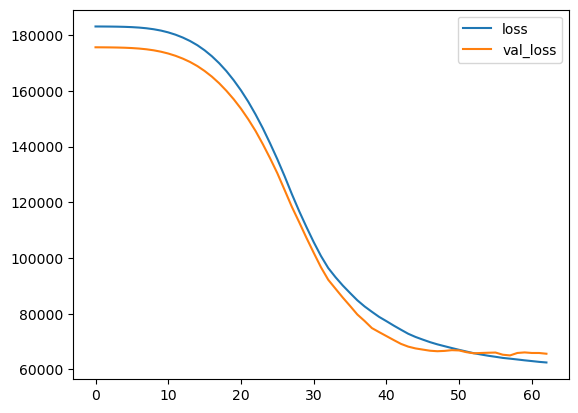

In [93]:
model.compile(
    optimizer='adam',
    loss='mae'
)
history = model.fit(
    X_train_used, Y_train_used,
    validation_data=(X_valid_used, Y_valid_used),
    batch_size = int(X_train_used.shape[0]/10),
    epochs=200,
    callbacks=[early_stopping],
    verbose = 1
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();

In [94]:
Y_train_pred = model.predict(X_train_arr)

46/46 [==============================] - 0s 2ms/step


2023-01-23 16:44:00.221622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


### Neural Network with SKLearn

In [135]:
# scikit-learn
# https://scikit-learn.org/stable/tutorial/basic/tutorial.html

from sklearn.neural_network import MLPRegressor

Num_Hidden = 256
# model = MLPRegressor(hidden_layer_sizes = Num_Hidden, 
#                      learning_rate_init = 0.03,
#                      max_iter=5000, random_state=1000)

# %time model.fit( x.reshape(-1,1), y )


# you can also try two hidden layers, see the performance...
# hidden_layer_sizes: tuple, the ith element represents the number of neurons in the ith hidden layer.
model = MLPRegressor(hidden_layer_sizes = (Num_Hidden, int(Num_Hidden/2)), 
                     learning_rate_init = 0.03,
                     max_iter=5000, random_state=1000, solver='adam', early_stopping=True)

%time model.fit( X_train_scale, Y_train )


/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  

CPU times: user 6.72 s, sys: 341 ms, total: 7.06 s
Wall time: 1.73 s


/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(


MLPRegressor(early_stopping=True, hidden_layer_sizes=(256, 128),
             learning_rate_init=0.03, max_iter=5000, random_state=1000)

In [136]:
Y_train_pred = model.predict(X_train_arr)

/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(


### Gridsearch

In [176]:
param_grid = {
    'hidden_layer_sizes': [(120,80,40), 150, (150, 75)],
    'max_iter': [150, 250],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.75, 0.05],
    'learning_rate': ['constant','adaptive'],
    'early_stopping': [True,False]
}

In [160]:
model = MLPRegressor(hidden_layer_sizes = (Num_Hidden, int(Num_Hidden/2)), 
                     learning_rate_init = 0.03, random_state=1000, solver='adam', early_stopping=False)

In [177]:
grid = GridSearchCV(MLPRegressor(), param_grid, n_jobs= -1, cv=5, verbose=0)
grid.fit(np.array(X_train_scale), Y_train)

print(grid.best_params_)

/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't conv

/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't conv

/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't conv

/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't conv

/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't conv

/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't conv

/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't conv

/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/utils/extmath.py:189: RuntimeWa

/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/yogi/miniconda3/envs/tensorflow/lib/pyt

/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/yogi/miniconda3/envs/tensorflow/lib/pyt

/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't conv

/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't conv

/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sk

/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer:

/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_base.py:174: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn'

/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't conv

/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't conv

/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/yogi/miniconda3/envs/tensorflow/lib/pyt

/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/yogi/miniconda3/envs/tensorflow/lib/pyt

/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/yogi/miniconda3/envs/tensorflow/lib/pyt

/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/yogi/miniconda3/envs/tensorflow/lib/pyt

/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_base.py:174: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_base.py:174: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/yogi/miniconda3/env

/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't conv

/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't conv

/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maxi

/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't conv

/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_base.py:174: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn'

/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't conv

{'activation': 'relu', 'alpha': 0.05, 'early_stopping': False, 'hidden_layer_sizes': (120, 80, 40), 'learning_rate': 'constant', 'max_iter': 250, 'solver': 'adam'}


/Users/yogi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


In [178]:
Y_train_pred = grid.predict(X_train_arr)

## Root Mean Squared Error

In [20]:
from sklearn.metrics import mean_squared_error
import math

In [21]:
train_eval_metrics = math.sqrt(mean_squared_error(Y_train_pred, Y_train))

In [22]:
train_eval_metrics

11162.141916053128

### Deep Neural Network

In [95]:
train_eval_metrics = math.sqrt(mean_squared_error(Y_train_pred, Y_train))

In [96]:
train_eval_metrics

88481.38445301341

### NN with Sklearn

In [164]:
train_eval_metrics = math.sqrt(mean_squared_error(Y_train_pred, Y_train))

In [165]:
train_eval_metrics

6016.36101398601

In [179]:
train_eval_metrics = math.sqrt(mean_squared_error(Y_train_pred, Y_train))

In [180]:
train_eval_metrics

19246.61839753955

# Test Dataset

In [181]:
test_df = pd.read_csv('data/test.csv')

In [182]:
X_test, y_test = X_preprocessing(test_df)

This is test dataset return only X...


## Adjust the column of train and test datasource

In [86]:
X_train_scale_final, X_test = X_train_scale.align(X_test, join = 'left', axis=1)

### Using z-scaler to transform it

In [87]:
X_test_scale = scaler.transform(X_test)
X_test_scale_final = pd.DataFrame(X_test_scale, columns= X_test.columns)

X_test_scale_final = X_test_scale_final.fillna(0)

In [27]:
Y_test_pred = random_forest.predict(np.array(X_test_scale_final))

In [28]:
df_submission = pd.DataFrame(Y_test_pred, index=range(1461, 2920))
df_submission.columns = ['SalePrice']
df_submission.index.name = 'Id'

In [29]:
df_submission.to_csv('submission_15_january_2023.csv')

---

### Submission using DL

In [88]:
Y_test_pred = model.predict(np.array(X_test_scale_final))

46/46 [==============================] - 0s 3ms/step


2023-01-23 16:40:45.161897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [89]:
df_submission = pd.DataFrame(Y_test_pred, index=range(1461, 2920))
df_submission.columns = ['SalePrice']
df_submission.index.name = 'Id'

In [90]:
df_submission.to_csv('Deep_learning_23_january_2023.csv')

### Submission using NeuralNet (SKLearn)

In [183]:
Y_test_pred = grid.predict(np.array(X_test_scale_final))

In [184]:
df_submission = pd.DataFrame(Y_test_pred, index=range(1461, 2920))
df_submission.columns = ['SalePrice']
df_submission.index.name = 'Id'

In [185]:
df_submission.to_csv('NN_sklearn_23_january_2023.csv')

# Resources

https://towardsdatascience.com/7-data-types-a-better-way-to-think-about-data-types-for-machine-learning-939fae99a689

https://medium.com/analytics-vidhya/ways-to-handle-categorical-column-missing-data-its-implementations-15dc4a56893#:~:text=Step%201%3A%20Find%20which%20category,and%20keep%20newly%20imputed%20columns.&text=Advantage%3A%20Simple%20and%20easy%20to%20implement%20for%20categorical%20variables%2Fcolumns.



https://stackoverflow.com/questions/62653114/how-can-i-deal-with-this-git-warning-pulling-without-specifying-how-to-reconci